# 01 - Explainability

Use this notebook to explain your model predictions

At this point we assume we have already trained a model that we now wish to explain.

If you want to check out the preceding steps, you can check out the rest of the repo (or if you want to train a different model or use different preprocessing & feature engineering settings)



# TODO EXPLAIN WHY SHAP AND WHY SOME OTHER PACKAGES (DIFFERENCES, ADVANTAGES)

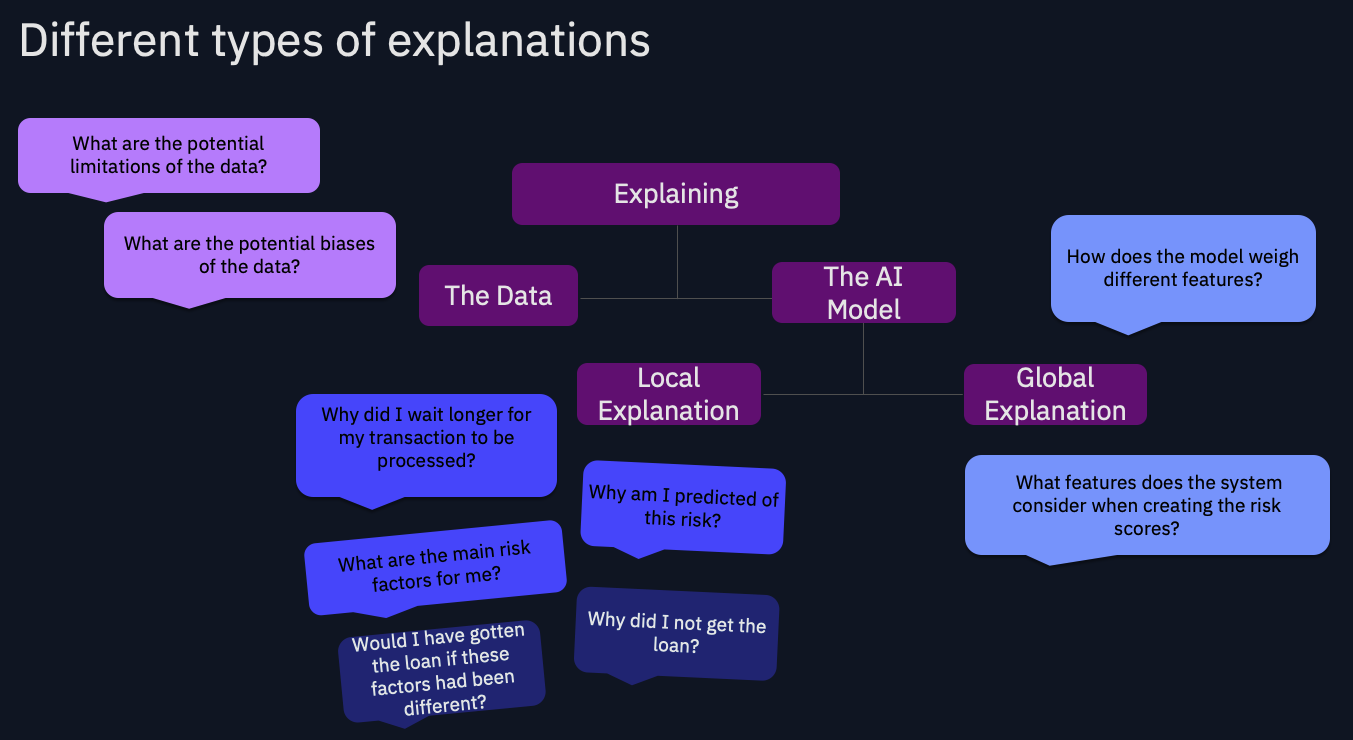

In [5]:
# TODO add in markdown instead of code
from IPython.display import Image
Image("img/Explainability Types.png")

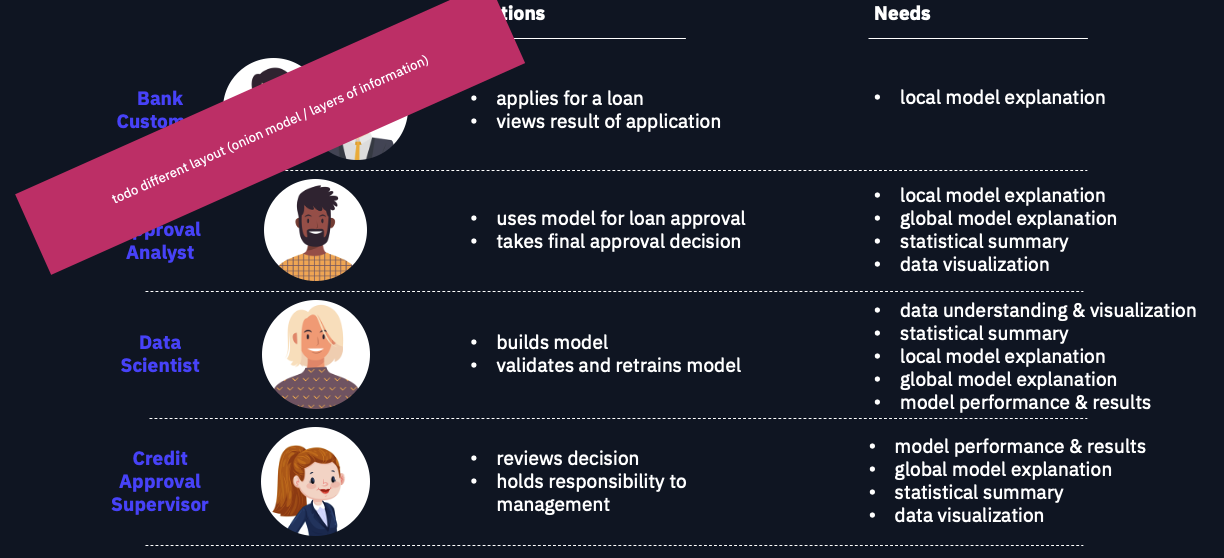

In [6]:
Image("img/Explainability Needs.png")

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import shap
# print the JS visualization code to the notebook
shap.initjs()